In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image
from datetime import datetime
import PIL.ExifTags

import dateutil.parser
import os
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [11]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 266
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 10
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 3

# Number of wells per horizontal(!) line per concentrations
# full chip equals 10
n_wells = 1

# How many hours did the experiment last?
hours_of_experiment = 17


# How many pictures where taken per hour per well?
images_per_hour = 1

###### delete hoe and iph, use this instead
# total amount of images
total_n_images = 102
n_timepoints = int(total_n_images / (number_of_diff_conc * n_wells * 2)) 

# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 55


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
#image_folder = "C:Users/DigitalStation/Documents/Universität Stuttgart/Institut für industrielle Bioverfahrenstechnik/1_Masterthesis/Experiments/20210804 First OFM Exp/Images"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages"

image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220601 BSA PEG FC40"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages3"

# datatype of the images
extension = ".jpg"

# TODO: use a .yml file for storing these variables

In [ ]:
#THIS IS FOR CELLOBSERVER/ZEISS IMAGES ONLY

def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
pypc.images_to_list(image_list, image_names, image_folder, extension)
pypc.images_to_dict(hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells, image_list, image_names, time_resolution, concentration, well, data_well)

# Two possibilities:
# use script if you did a pipetting series
starting_concentrations = pypc.starting_concentration(initial_conc_sol1, initial_conc_sol2, initial_ratio)
# or
# write list


well_nr = 0
for conc_nr in range(number_of_diff_conc):
    for n_rows_per_conc in range(2):
        for n_wells_per_row in range(n_wells):
            
            # Initialise variables, arrays and lists
            well_data = np.zeros(shape=(2, 3))
            centerpoints = np.zeros(shape=(2, 2))
            elon_mask = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
            threshed_img = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
            areas = np.zeros(shape=(1, 2))
            droplet_arr = np.zeros(shape=(2,4))
            r_old_hv = np.zeros(2)
            mean_list = []
            llps_status = False
            r_0 = 0
            n_0 = 0
            r_droplet_old = 0
            avg_sum_prev = 0
            
            for time_idx in range(n_timepoints): #n_timepoints
                if llps_status is False:
                    print("---", "C:", conc_nr, "W:", well_nr, " T:", time_idx, "---")

                    image = time_resolution[time_idx][conc_nr][well_nr]['gray'].copy()

                    well_data, elon_mask, masked_img, droplet_found, norm_pp_len_h,norm_pp_len_v, img, f, N, E, S, W, x, y, droplet_arr, radius_old_hv, hor, vert, r_0, avg_sum_prev, droplet_coords = pypc.droplet_detection(diameter, image, well_data, elon_mask, centerpoints, llps_status, droplet_arr, r_0, time_idx, r_old_hv, r_droplet_old, avg_sum_prev)
 
                    time_resolution[time_idx][conc_nr][well_nr]['img'] = img
                    time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_h'] = norm_pp_len_h # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_v'] = norm_pp_len_v # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['masked img'] = masked_img 
                    time_resolution[time_idx][conc_nr][well_nr]['manipulated img'] = img # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['droplet data'] = droplet_arr.copy()
                    time_resolution[time_idx][conc_nr][well_nr]['x'] = x # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['y'] = y # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['r'] = well_data[0, 2] # needed for display
                    time_resolution[time_idx][conc_nr][well_nr]['N'] = N
                    time_resolution[time_idx][conc_nr][well_nr]['E'] = E
                    time_resolution[time_idx][conc_nr][well_nr]['S'] = S
                    time_resolution[time_idx][conc_nr][well_nr]['W'] = W
                    
                    time_resolution[time_idx][conc_nr][well_nr]['well data'] = well_data
                    time_resolution[time_idx][conc_nr][well_nr]['mask'] = elon_mask
                    time_resolution[time_idx][conc_nr][well_nr]['hor'] = hor
                    time_resolution[time_idx][conc_nr][well_nr]['vert'] = vert
                    

                    time_resolution[time_idx][conc_nr][well_nr]['coords'] = droplet_coords

                    
                    if time_idx == 0:
                        areas[0, 0] = droplet_arr[0, 3]

                    llps_status, areas, mean_list, droplet_arr, squi, cro_squi, n_0 = pypc.detect_LLPS(percental_threshold, droplet_arr, llps_status, img, time_idx, areas, mean_list, droplet_found, n_0)
                    time_resolution[0][conc_nr][well_nr]['areas'] = areas
                    time_resolution[0][conc_nr][well_nr]['mean list'] = mean_list
                    time_resolution[time_idx][conc_nr][well_nr]['squ'] = squi
                    time_resolution[time_idx][conc_nr][well_nr]['cro squ'] = cro_squi
                    
                    time_resolution[time_idx][conc_nr][well_nr]['droplet array'] = droplet_arr

                    print("LLPS status: ", llps_status)
                    if llps_status is True:
                        # save img time where llps was found
                        time_resolution[0][conc_nr][well_nr]['time idx'] = time_idx
                        # save name of image where LLPS was detected
                        time_resolution[0][conc_nr][well_nr]['LLPS name'] = time_resolution[time_idx][conc_nr][well_nr]['name']
                        # calculate the critical concentration
                        print("c_crit calculation input: ", starting_conc, "areas:", areas, conc_nr)
                        llps_conc = pypc.ccrit_calculation(starting_conc, areas, conc_nr)
                        time_resolution[0][conc_nr][well_nr]['LLPS conc'] = llps_conc
                    
            well_nr += 1
    well_nr = 0



# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)

Creating and sorting image list


100%|███████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 154.73it/s]


writing images into big dictionary


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 135.53it/s]


--- C: 0 W: 0  T: 0 ---
detect wells & droplets and create masks
- well found: True
mid_start: 132
366.0 208.0 // 518.0 208.0
0 0 L: 56.0 R: 208.0 m: 132.0
339.0 238.0 // 543.0 238.0
0 1 L: 29.0 R: 233.0 m: 131.0
328.0 268.0 // 554.0 268.0
0 2 L: 18.0 R: 244.0 m: 131.0
324.0 298.0 // 550.0 298.0
0 3 L: 14.0 R: 240.0 m: 127.0
327.0 328.0 // 557.0 328.0
0 4 L: 17.0 R: 247.0 m: 132.0
339.0 358.0 // 545.0 358.0
0 5 L: 29.0 R: 235.0 m: 132.0
362.0 388.0 // 522.0 388.0
0 6 L: 52.0 R: 212.0 m: 132.0
x_d [366. 518. 339. 543. 328. 554. 324. 550. 327. 557. 339. 545. 362. 522.]
mid_start: 132
1 0 L: 57.0 R: 212.0 m: 134.0
1 1 L: 31.0 R: 237.0 m: 134.0
1 2 L: 18.0 R: 250.0 m: 134.0
1 3 L: 14.0 R: 253.0 m: 133.0
1 4 L: 14.0 R: 250.0 m: 132.0
1 5 L: 30.0 R: 237.0 m: 133.0
1 6 L: 57.0 R: 212.0 m: 134.0
x_d [352. 352. 382. 382. 412. 412. 442. 442. 472. 472. 502. 502. 532. 532.]
DROPLET VALUES horizontal: 440.8273509867721 299.6321642226663 vertical: 442.40253296353126 299.5425631220779
DROPLET ARRAY I

In [4]:
for c in range(3):
    for w in range(2):
        print(time_resolution[0][c][w]['time idx'])

6
6
5
3
7
8


In [ ]:
c = 2
w = 1
t = 3

x_abs = time_resolution[t][c][w]['x abs']
y_abs = time_resolution[t][c][w]['y abs']
radius_est = time_resolution[t][c][w]['radius'] 

fig, axs = plt.subplots(1,2, figsize=(15, 9), facecolor='w', edgecolor='k')
axs[0].imshow(time_resolution[t][c][w]['squ'], cmap="gray")
axs[1].imshow(time_resolution[t][c][w]['cro squ'], cmap="gray")

circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:blue', alpha=0.25)

axs[0].add_patch(circle)

print("whitespace", np.count_nonzero(time_resolution[t][c][w]['cro squ']))
print("r", time_resolution[t][c][w]['radius'])
print("meanlist", time_resolution[0][c][w]['mean list'])



n = 0
for idx, value in enumerate(time_resolution[t][c][w]['cro squ']):
    for i, val in enumerate(time_resolution[t][c][w]['cro squ'][idx]):
        if val == 0:
            n += 1

# changed: removed abs() from droplet detector

radius 97.52479965475072
115.0 97.52479965475072


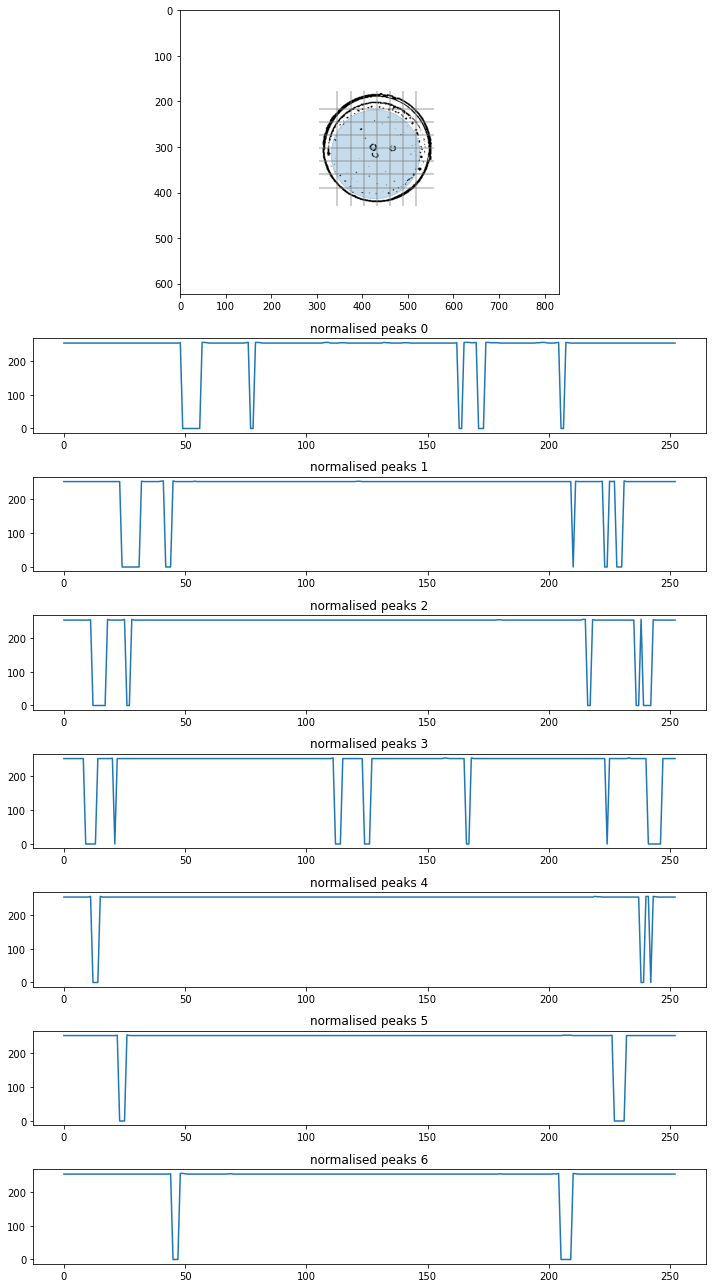

In [20]:
### Plot


conc_nr = 1
well_nr = 0
time_idx = 4



img = time_resolution[time_idx][conc_nr][well_nr]['img'] 
norm_pp_len_h = time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_h']
x_abs = time_resolution[time_idx][conc_nr][well_nr]['droplet data'][0, 1]
y_abs = time_resolution[time_idx][conc_nr][well_nr]['droplet data'][0, 2]
radius_est = time_resolution[time_idx][conc_nr][well_nr]['droplet data'][0, 0]
x = time_resolution[time_idx][conc_nr][well_nr]['x'] 
y = time_resolution[time_idx][conc_nr][well_nr]['y']
r = time_resolution[time_idx][conc_nr][well_nr]['r'] 
N = time_resolution[time_idx][conc_nr][well_nr]['N'] 
E = time_resolution[time_idx][conc_nr][well_nr]['E'] 
S = time_resolution[time_idx][conc_nr][well_nr]['S'] 
W = time_resolution[time_idx][conc_nr][well_nr]['W'] 

print("radius", radius_est)
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 18), gridspec_kw={"height_ratios": [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]})
ax1.imshow(img, cmap="gray")
print(r, radius_est)



#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax1.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + (0.5 * r) / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)

ax1.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)


#circle = plt.Circle((x_ass, y_ass), radius, color='tab:red', alpha=0.25)
circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:blue', alpha=0.25)

ax1.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)

ax2.plot(norm_pp_len_h[0])
ax2.set_title("normalised peaks 0")

ax3.plot(norm_pp_len_h[1])
ax3.set_title("normalised peaks 1")

ax4.plot(norm_pp_len_h[2])
ax4.set_title("normalised peaks 2")

ax5.plot(norm_pp_len_h[3])
ax5.set_title("normalised peaks 3")

ax6.plot(norm_pp_len_h[4])
ax6.set_title("normalised peaks 4")

ax7.plot(norm_pp_len_h[5])
ax7.set_title("normalised peaks 5")

ax8.plot(norm_pp_len_h[6])
ax8.set_title("normalised peaks 6")

#ax9.plot(l, np.sum(norm_pp_len_h, axis=0))
#ax9.set_title("summed peaks")
#ax9.hlines(5, np.min(l),np.max(l), color="tab:orange")
fig.tight_layout()
#fig.savefig(f"t{time_idx}_c{conc_nr}_w{well_nr}_self-dev-Algo.png")

In [ ]:
a = 3.14 * 120**2
b = 3.14 * 118**2
print(b/a)

In [ ]:
### Plot
img = time_resolution[time_idx][conc_nr][well_nr]['img'] 
norm_pp_len_v = time_resolution[time_idx][conc_nr][well_nr]['normg_pp_len_v']
l_vert = time_resolution[time_idx][conc_nr][well_nr]['l_vert'] 




fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, figsize=(10, 18), gridspec_kw={"height_ratios": [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]})
ax1.imshow(img, cmap="gray")


#img_hL = cv2.line(img.copy(), (W,y), (E,y), (255,0,0), 2)
ax1.hlines(y, W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + (0.5 * r) / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 0.5 * r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - r / 2), W, E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y + 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)
ax1.hlines(int(y - 1.5 * r/2), W,E, color="tab:gray", alpha=0.5)

ax1.vlines(x, N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 0.5 * r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - r / 2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x + 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)
ax1.vlines(int(x - 1.5 * r/2), N, S, color="tab:gray", alpha=0.5)


#circle = plt.Circle((x_ass, y_ass), radius, color='tab:red', alpha=0.25)
circle = plt.Circle((x_abs, y_abs), radius_est, color='tab:red', alpha=0.25)
#circle = plt.Circle((x_abs, 110+y-2*radius_est), radius_est, color='tab:green', alpha=0.25)


ax1.add_patch(circle)
#ax1.hlines(y_ass, x_ass-10, x_ass+10, color='tab:blue', linewidth=5)

ax2.plot(norm_pp_len_v[0])
ax2.set_title("normalised peaks 0")

ax3.plot(norm_pp_len_v[1])
ax3.set_title("normalised peaks 1")

ax4.plot(l_vert, norm_pp_len_v[2])
ax4.set_title("normalised peaks 2")

ax5.plot(l_vert, norm_pp_len_v[3])
ax5.set_title("normalised peaks 3")

ax6.plot(l_vert, norm_pp_len_v[4])
ax6.set_title("normalised peaks 4")

ax7.plot(l_vert, norm_pp_len_v[5])
ax7.set_title("normalised peaks 5")

ax8.plot(l_vert, norm_pp_len_v[6])
ax8.set_title("normalised peaks 6")
fig.tight_layout()
#fig.savefig("t2_c0_w1_nuMethod.png")

In [ ]:
conc_nr = 2
well_nr = 0
time_idx = 3

c = 5
fig, axs = plt.subplots(c,1, figsize=(15, 6), facecolor='w', edgecolor='k')


axs = axs.ravel()

for t in range(c):
    print(t)
    axs[t].plot(time_resolution[t][conc_nr][well_nr]['normg_pp_len_v'][0])

for t in range(c):
    axs[t].plot(time_resolution[t][conc_nr][well_nr]['vert'][0])


## quality control

In [ ]:
#5,0,0

# time to check
time_idx = 5

# concentration to check
conc_nr = 0

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
pypc.quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['well geometry'])

In [8]:
if np.all(time_resolution[0][2][0]['LLPS conc']) != 0:
    print("true")

<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-a61565911492>:1: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if np.all(time_resolution[0][2][0]['LLPS conc']) != 0 is True:


## Plot the data

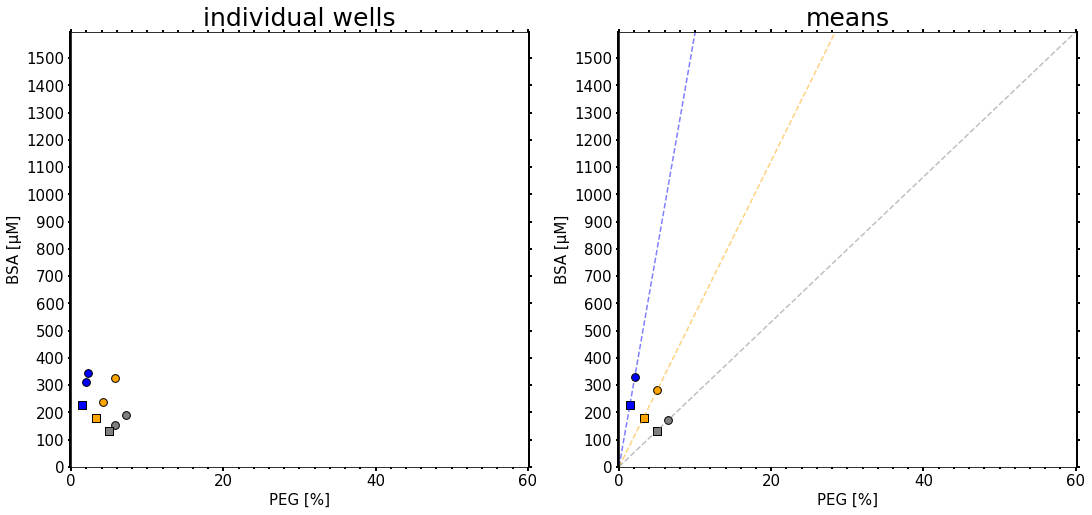

In [16]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol2 * 6)
ylim = int(initial_conc_sol1 * 6)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_locator(AutoMinorLocator(20))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_locator(AutoMinorLocator(20))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
    for n_horizontals_per_conc in range(2):
        for n_wells_per_horizontal in range(n_wells):
            if np.all(time_resolution[0][conc_nr][well_nr]['LLPS conc']) != 0:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
    well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
    for n_horizontals_per_conc in range(2):
        for n_wells_per_horizontal in range(n_wells):
            if np.all(time_resolution[0][conc_nr][well_nr]['LLPS conc']) != 0:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
    well_nr = 0
well_nr = 0


for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol1[conc_nr]/mean_sol2[conc_nr]
        
    ax2.plot([0, mean_sol2[conc_nr],xlim], [0, mean_sol1[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[conc_nr],mean_sol1[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 